** Our goal is to create optimal Skoltech schedule. **

Lets use the following notation:
$$ A_{chd} \in \{0,1\},$$ 

where $c = \overline {1 \dots n} \quad$ - the class index, $ h \in \{1, 2, 3\}$ - hour index, and $d \in\{1,2,3, 4\}$ refers to the one of the four studiyng days. Then, the tensor $A_{chd}$ containts information about whether the class $c$ is going to be
taught at hour slot $h$ on the day $d$ ($A_{chd} = 1$) or not ($A_{chd} = 0$).

## Objective
One of the possible ways to model objective of this optimization problem is to make our schedule mor or less uniform:

$$ \min\limits_A \quad \sum\limits_{h = 1}^{3} \sum\limits_{d = 1}^{4}{\Bigl(\sum\limits_{c=1}^{n} A_{chd}\Bigr)}^2 $$



### AND
 we want to have classes at the same our slot during the weekend (Thank you, Anton!):
 $$ \min\limits_A \quad \sum\limits_{c = 1}^{n} \sum\limits_{h = 1}^{3}\sum\limits_{i \ne j} \Bigl|A_{chd_i}- A_{chd_j}\Bigr| $$
 
 After summarizing all overdescribed, we will get th following objective:
 $$ \min\limits_A \quad \sum\limits_{h = 1}^{3} \sum\limits_{d = 1}^{4}{\Bigl(\sum\limits_{c=1}^{n} A_{chd}\Bigr)}^2
                        +\sum\limits_{c = 1}^{n} \sum\limits_{h = 1}^{3}\sum\limits_{i \ne j} \Bigl|A_{chd_i}- A_{chd_j}\Bigr| $$
 
## Constraints
Our **Edu** office told us that we have two types of constraints which we should take into consideration:
* The number of hours of each class is defined:
$$ \sum\limits_{d ,h} A_{cdh} \ge {\alpha}_c, \quad c = 1 \dots n$$
* The are pairs (the three) of classes that should not be intersected within one hour slot (core courses):
$$ A_{c_ihd} + A_{c_jhd} \le 1, \quad \forall  \quad h, d $$
* We assume, that studients want to attend different classes within one day:
$$ \sum\limits_{h = 1}^{3} A_{chd} \le 1, \quad \forall c, d $$
# What else?

In [1]:
import numpy as np
import gurobipy as grb
from cvxpy import *

titles=['Intellectual Property and Technological Innovation',
        'Introduction to Composite Materials and Structures',
        'Thermal Fluid Sciences',
        'Petroleum Geophysics',
        'Introduction Device Physics',
        'Materials Chemistry',
        'Mathematical Methods of Optical Communication',
        'Quantum Fluids',
        'Introduction to Power Systems',
        'Bayesian Methods - Adv Machine Learning',
        'Numerical methods for Partial Differential Equations',
        'Bioinformatics Lab Course 2',
        'RNA Biology',
        'Stem Cells',
        'Space Sector Course',
        'Dynamic Systems and Control'
        ]
n = len(titles)
h = 3  # hours slots
d = 4  # number of days
m = d*h

In [2]:
import cvxpy
A = Bool(n, m)
######### first type of constraints ##########
alpha = np.array([3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2], dtype = int) 
constraints = [sum_entries(A[i,:]) >= alpha[i] for i in range(n)]
######## second type of constraints #########
for j in range(m):
    constraints.append(A[2,j] + A[3, j] + A[8, j] <= 1)
   
for j in range(m):
    constraints.append(A[2,j] + A[3, j] <= 1)
    
for j in range(m):
    constraints.append(A[4,j] + A[6, j] + A[7, j] <= 1)

for j in range(m):
    constraints.append(A[3,j] + A[8, j] <= 1)
    
for j in range(m):
    constraints.append(A[11,j] + A[12, j] + A[13, j] <= 1)

expr = Constant(0)    
for i in xrange(n):
    for j in xrange(h):
        expr = expr + cvxpy.abs(A[i, j] - A[i, j + 3]) + \
            cvxpy.abs(A[i, j] - A[i, j + 6]) + \
            cvxpy.abs(A[i, j] - A[i, j + 9]) + \
            cvxpy.abs(A[i, j + 3] - A[i, j + 6]) + \
            cvxpy.abs(A[i, j + 3] - A[i, j + 9]) + \
            cvxpy.abs(A[i, j + 6] - A[i, j + 9])
            
##### third type of constrints ###########

for i in xrange(n):
    for j in xrange(0, 12, 3):
        constraints.append(sum_entries(A[i, j:j+3]) <= 1)
     
objective = Minimize(sum_entries(square(sum_entries(A, axis= 0))) + expr)
prob = Problem(objective, constraints)

kwargs = { 'timeLimit': 160 }
prob.solve(solver = 'GUROBI', verbose = True, **kwargs)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter TimeLimit to 160.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 752 rows, 528 columns and 2520 nonzeros
Model has 12 quadratic constraints
Coefficient statistics:
  Matrix range    [1e+00, 2e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 3e+00]
Presolve removed 36 rows and 12 columns
Presolve time: 0.05s
Presolved: 716 rows, 516 columns, 2448 nonzeros
Variable types: 312 continuous, 204 integer (192 binary)

Root relaxation: objective -1.200000e+01, 231 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -12.00000    0   16          -  -12.00000      -     -    0s
     0     0   53.06433    0  

209.99999098772528

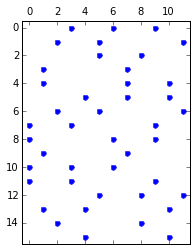

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
B = np.zeros((n, m))
B = np.copy(np.asarray(A.value))
plt.spy(B, marker = '.')


In [4]:
###### Printing results ######

days = ['Monday', 'Tuesday', 'Thursday', 'Friday']
hours = ['1', '2', '3']
flag = True

for j in range(m):
    hd = []
    if (j%3 ==0):
        print days[j/3], ':'
        flag = False
    for k in range (n):
        if (B[k, j] == 1):
            hd.append(titles[k])
    print j%3+1, '-', hd

Monday :
1 - ['Quantum Fluids', 'Introduction to Power Systems', 'Numerical methods for Partial Differential Equations', 'Bioinformatics Lab Course 2']
2 - ['Petroleum Geophysics', 'Introduction Device Physics', 'Bayesian Methods - Adv Machine Learning', 'Stem Cells']
3 - ['Introduction to Composite Materials and Structures', 'Mathematical Methods of Optical Communication', 'Space Sector Course']
Tuesday :
1 - ['Intellectual Property and Technological Innovation', 'Quantum Fluids', 'Numerical methods for Partial Differential Equations', 'Bioinformatics Lab Course 2']
2 - ['Materials Chemistry', 'Stem Cells', 'Dynamic Systems and Control']
3 - ['Introduction to Composite Materials and Structures', 'Thermal Fluid Sciences', 'Mathematical Methods of Optical Communication', 'RNA Biology']
Thursday :
1 - ['Intellectual Property and Technological Innovation', 'Introduction to Power Systems', 'Numerical methods for Partial Differential Equations']
2 - ['Petroleum Geophysics', 'Introduction De

In [5]:
####### Results to dictionary ##########
schedule = {'Monday': [], 'Tuesday': [], 'Thursday': [], 'Friday': []}

for i in schedule.keys():
    for j in range(h):
        schedule[i].append([])
        
for j in range(m):
    for k in range(n):
        if (B[k, j] == 1):
            schedule[schedule.keys()[j//h]][j%h].append(titles[k])
    

In [6]:
# rooms list
# without '450 Space Lab' because we should only assign space to it
rooms = ['401', '402', '403', '407', '408', '421', '423', '441CL', '404 CL']

# dates for stub
dates = ['Feb 1, 8, 15, 22, 29', 'Feb 2, 9, 16', 'Feb 3, 10, 17, 24', 'Feb 4, 11, 18, 25', 'Feb 5, 12, 19, 26']

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

In [8]:
import xlsxwriter
from datetime import datetime, timedelta
import colorsys
from struct import pack

workbook = xlsxwriter.Workbook('schedule.xlsx')
ws = workbook.add_worksheet()

np.random.seed(42)
color = np.random.rand()

glob = {
    'bold': 1,
    'border': 1,
    'align': 'center',
    'valign': 'vcenter',
    'font_name': 'Arial',
    'font_size': 10,
    'fg_color': 'white'}

global_format = workbook.add_format(glob)
frm_light = workbook.add_format(glob)
frm_dark = workbook.add_format(glob)
frm_light.set_pattern(1)
frm_dark.set_pattern(1)
frm_light.set_bg_color('#FFFFCC')
frm_dark.set_bg_color('#FFFF99')

for i in range(26):
    for j in range(32):
        ws.write(i, j, None, global_format)

ws.set_row(0, 30)
ws.set_row(1, 30)
ws.set_row(2, 30)
ws.set_row(3, 30)

ws.merge_range('A1:A4', None)

def add_time_col(ws):
    ws.set_column('A:A', 10)
    date_time = datetime.strptime('2016-02-01 09:00:00.000',
                              '%Y-%m-%d %H:%M:%S.%f')
    dt_str = date_time.strftime("%H:%M")    
    
    # 22 time intervals
    for i in xrange(4, 4 + 22):
        ws.set_row(i, 17)
        if (i - 3) == 8:
            next_dt = date_time + timedelta(0,12*60*60+30*60)
        else:
            next_dt = date_time + timedelta(0,30*60)
            
        value = dt_str + ' - ' + next_dt.strftime("%H:%M")
        date_time = next_dt
        dt_str = date_time.strftime("%H:%M")
        
        if ((i - 3) % 7) == 0 and (i-3) < 15:
            ws.write_string(i, 0, value, frm_dark)
        else:
            ws.write_string(i, 0, value, frm_light)
            
add_time_col(ws)
    
#def init_classes():

# http://devmag.org.za/2012/07/29/how-to-choose-colours-procedurally-algorithms/
def gen_color():
    global color
    gr = 0.618033988749895
    color += gr
    color %= 1.
    color_t = (color, 0.5, 0.95)
    rgb_color = colorsys.hsv_to_rgb(*color_t)
    rgb = (np.int(rgb_color[0]*255), np.int(rgb_color[1]*255), np.int(rgb_color[2]*255))
    return '#'+pack("BBB",*rgb).encode('hex')

cls_formats = {}
def get_class_format(cls):
    if not cls in cls_formats:
        class_format = workbook.add_format(glob)
        class_format.set_rotation(90)
        class_format.set_pattern(1)
        class_format.set_bg_color(gen_color())
        class_format.set_text_wrap()
        cls_formats[cls] = class_format
        
    return cls_formats[cls]

def add_day(row_num, col_num, day_name, date_str):
    if not day_name in schedule:
        return 0
    
    width = 0
    
    for i in xrange(3):
        width = max(len(schedule[day_name][i]), width)
    
    width = max(6, width)
    
    ws.merge_range(row_num, col_num, row_num, col_num + width - 1, date_str, frm_light)
    row_num += 1
    ws.merge_range(row_num, col_num, row_num, col_num + width - 1, day_name, global_format)
    row_num += 1
    
    for i in xrange(width):
        ws.write_string(row_num, col_num + i, rooms[i], frm_dark)
    
    row_num += 1
    
    for i in xrange(3):
        
        for j, c in enumerate(schedule[day_name][i]):
            ws.merge_range(row_num, col_num + j, row_num + 5, col_num+j, c, get_class_format(c))
        
        it = len(schedule[day_name][i])
        
        for j in xrange(width - it):
            ws.merge_range(row_num, col_num + j + it, row_num + 5, col_num + j + it, None)
        
        ws.merge_range(row_num + 6, col_num, row_num + 6, col_num + width - 1, None, frm_dark)
        
        row_num += 7
        
    return width

i = 0
offset = 1
# adding all the days
for day in days:
    offset += add_day(1, offset, day, dates[i])
    i += 1

# header
ws.merge_range(0, 1, 0, offset - 1, "WEEK 1", global_format)
    
workbook.close()